# LoG Blob Detection
## Gabriele Marino

In [1]:
from scipy import spatial
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

## 1. Convolution Implementation

In [2]:
def convolve(image, kernel):

    """
    Perform the convolution of a kernel over an image.

    Params
    ------
    image:
        The image to convolve, in gray scale.
    kernel:
        The kernel to convolve. It is assumed to be squared and with odd size.

    Returns
    -------
    The result of the convolution of the given kernel over the given image.

    """

    image_height, image_width = image.shape
    kernel_size = kernel.shape[0]

    # Padding is performed by replicating the border of the input image
    # This ensures consistency between the dimension of the input image and that of the result
    pad = kernel_size // 2
    image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REPLICATE)

    # Convolution is performed from left to right, top to bottom
    result = np.zeros((image_height, image_width))
    for y in range(image_height):
        for x in range(image_width):
            result[y, x] = np.sum(kernel * image[y : y + kernel_size, x : x + kernel_size])
    return result

## 2. LoG Filter Implementation

In [3]:
def LoG_filter(scale, filter_size=None):
    
    """
    Compute the Laplacian of a Gaussian filter for a given scale.

    Params
    ------
    scale:
        The scale of the Gaussian filter.
    filter_size:
        The size of the filter. If not odd, the size of the returned filter will be rounded to the nearest one.

    Returns
    -------
    The Laplacian of a Gaussian filter of the given scale.

    """
    
    if not filter_size:
        filter_size = 6 * scale
    
    y, x = np.ogrid[- (filter_size // 2) : filter_size // 2 + 1, - (filter_size // 2) : filter_size // 2 + 1]
    LoG_filter = - 1 / (np.pi * scale ** 4) * (1 - (x ** 2 + y ** 2) / (2 * scale ** 2)) * np.exp(- (x ** 2 + y ** 2) / (2 * scale ** 2))
    return LoG_filter

def normalized_LoG_filter(scale, filter_size=None):

    """
    Compute the normalized Laplacian of a Gaussian filter for a given scale.

    Params
    ------
    scale:
        The scale of the Gaussian filter.
    filter_size:
        The dimension of the filter. If not odd, the size of the returned filter will be rounded to the nearest one.

    Returns
    -------
    The normalized Laplacian of a Gaussian filter of the given scale.

    """
    
    return scale ** 2 * LoG_filter(scale, filter_size)

### 2.1 Visualizing the LoG Filter

To assert the correctness of the LoG Filter implementation, and for visualization purposes, the plots of the LoG Filter for different values of the scale are shown below.

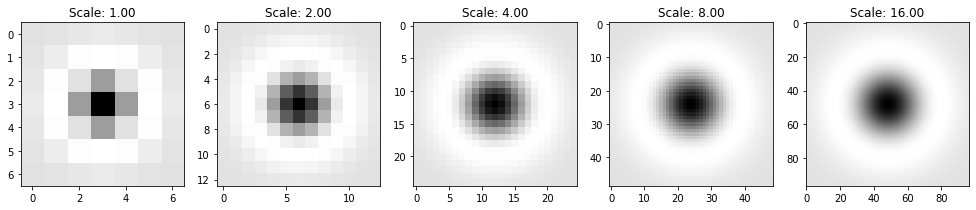

In [4]:
sigma_0 = 1
k = 2
scales_list = [sigma_0 * k ** j for j in range(0, 5)]

plt.figure(figsize = (17,7))
for i, scale in enumerate(scales_list):
    kernel = LoG_filter(scale)
    plt.subplot(1, 5, i + 1)
    plt.imshow(kernel, cmap="gray")
    plt.title("Scale: {:.2f}".format(scale))
plt.show()

The result looks good: the filter has the expected "Mexican Hat" shape.

### 2.2 LoG Responses

To assert the correctness of the convolution implementation and for visualization purposes, the filtering of a "toy" image is performed below.

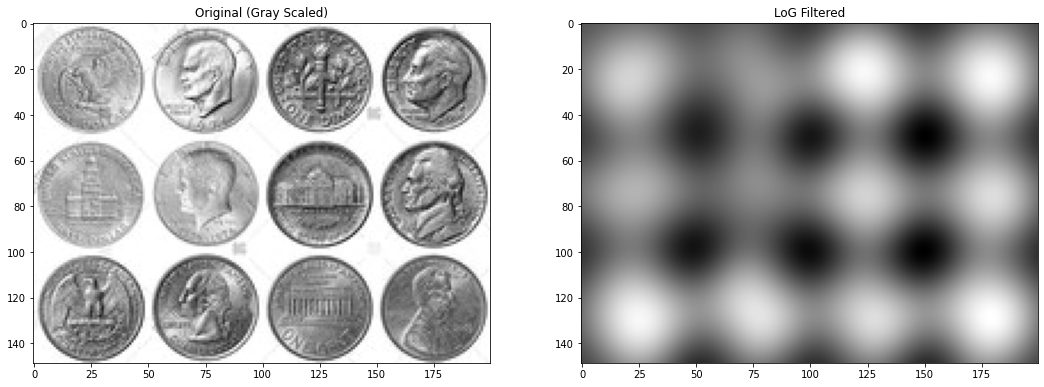

In [5]:
image = cv2.imread("data/coins.jpg")
gray_scaled_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(18,9))
plt.subplot(1, 2, 1)
plt.imshow(gray_scaled_image, cmap="gray")
plt.title("Original (Gray Scaled)")

scale = 15
kernel = LoG_filter(scale)
response = convolve(gray_scaled_image, kernel)
plt.subplot(1, 2, 2)
plt.imshow(response, cmap="gray")
plt.title("LoG Filtered")

plt.show()

The result is in accordance with the theory: dark blobs have high responses whilst bright blobs have low responses. In particular, the darker the blob, the higher its response.

## 3. LoG Blob Detection 

In [6]:
def squared_normalized_LoG_responses(image, scales_list, filter_sizes_list=None):

    """
    Compute the squared normalized LoG responses for the given scales.
    
    Params
    ------
    image:
        The image to process, in gray scale.
    scales_list:
        A list containing the values of the scale.
    filter_sizes_list:
        A list containing the size of the filter for each scale.

    Returns
    -------
    An array containing the squared normalized LoG responses for the given scales.
    
    """
    
    if not filter_sizes_list:
        filter_sizes_list = [None] * len(scales_list)
    
    responses = []
    for scale, filter_size in zip(scales_list, filter_sizes_list):
        kernel = normalized_LoG_filter(scale, filter_size)
        response = np.square(convolve(image, kernel))
        responses.append(response)
    return np.array(responses)

In [7]:
def detect_blobs(responses, scales_list, threshold=0, prune_border_blobs=False, min_border_distances=None):
    
    """
    Perform blob detection by maximazing the responses in the scale-space.

    Params
    ------
    responses: 
        The responses to maximize.
    scales_list: 
        A list containing the scale of each response.
    threshold: 
        The threshold for relevant maxima selection.
    prune_border_blobs:
        Specifies whether or not to prune the blobs closer to the image borders more than min_border_distance.
    min_border_distances: 
        A list specifying for each scale the minimum distance from the borders of the image for the blobs not to be pruned.
    
    Returns
    -------
    A list containing the coordinates of the blobs in the scale-space.
    
    """
    
    if not min_border_distances:
        min_border_distances = [math.ceil(scale) if prune_border_blobs else 0 for scale in scales_list]
    
    blobs = []
    for scale in range(responses.shape[0]):
        min_border_distance = min_border_distances[scale]
        for y in range(min_border_distance, responses.shape[1] - min_border_distance):
            for x in range(min_border_distance, responses.shape[2] - min_border_distance):
                # Each pixel is compared with all its neighbours in the space scale.
                # If it happen to be a relative maximum, and its value is greater than the thrshold, it is selected.
                neighbourhood = responses[max(0, scale-1) : scale+2, max(0, y-1) : y+2, max(0, x-1) : x+2]
                if np.all(responses[scale, y, x] >= neighbourhood) and responses[scale, y, x] > threshold:
                        blobs.append([y, x, scales_list[scale]])
    return np.array(blobs)

In [8]:
def circles_overlapping_ratio(r1, r2, d):

    """
    Compute the overlapping area ratio of two circles.
    
    Params
    ------
    r1:
        The radius of the first circle.
    r2:
        The radius of the second circle.
    d:
        The distance between the two circles.
    
    Returns
    -------
    The ratio between the overlapping area of the two circles and the area of the smallest one.
    
    Note
    ----
    Refer to: https://mathworld.wolfram.com/Circle-CircleIntersection.html.

    """
    
    ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
    ratio1 = np.clip(ratio1, -1, 1)
    acos1 = math.acos(ratio1)

    ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
    ratio2 = np.clip(ratio2, -1, 1)
    acos2 = math.acos(ratio2)

    a = -d + r2 + r1
    b = d - r2 + r1
    c = d + r2 - r1
    d = d + r2 + r1
    area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 - 0.5 * math.sqrt(abs(a * b * c * d)))
    return area / (math.pi * (min(r1, r2) ** 2))    


def blobs_overlapping_ratio(blob1, blob2):
    
    """
    Compute the overlapping area ratio between two blobs.
    
    Params
    ------
    blob1:
        The first blob.
    blob2:
        The second blob.
    
    Return
    ------
    The ratio between the overlapping area of the two blobs and the area of the smallest one.

    """
    
    r1 = math.sqrt(2) * blob1[-1]
    r2 = math.sqrt(2) * blob2[-1]
    
    d = math.sqrt(np.sum((blob1[:-1] - blob2[:-1]) ** 2))

    if d > r1 + r2: # The blobs are disjoint
        return 0.0
    elif d <= abs(r1 - r2): # One of the blobs falls inside the other
        return 1.0
    else:
        return circles_overlapping_ratio(r1, r2, d)


def remove_overlapping_blobs(blobs, overlapping_threshold=0.5):
    
    """
    Remove from a blobs array the blobs overlapping more than a given threshold.
    
    Params
    ------
    blobs:
        The blobs array.
    overlapping_threshold:
        The maximum overlapping between two blobs for them not to be pruned.
    
    Returns
    -------
    The given blobs array cleaned of the blobs overlapping more than the given threshold.
    
    Note
    ----
    This approch to overlapping blobs removal is inspired to skimage.feature.blob_log.
    For its source code refer to: https://github.com/scikit-image/scikit-image/blob/main/skimage/feature/blob.py
    
    """
    
    max_scale = blobs[:, -1].max()
    max_distance = 2 * math.sqrt(2) * max_scale # The maximum distance between two blobs for them to overlap
    blobs_tree = spatial.cKDTree(blobs[:, :-1])
    pairs = blobs_tree.query_pairs(max_distance) # Set of the pairs of all blobs which may overlap
    for i, j in pairs:
        blob1, blob2 = blobs[i], blobs[j]
        if blobs_overlapping_ratio(blob1, blob2) > overlapping_threshold:
            # The smaller blob is marked for removal
            if blob1[-1] > blob2[-1]:
                blob2[-1] = 0
            else:
                blob1[-1] = 0
    return blobs[np.where(blobs[:, -1] > 0)]

In [9]:
def LoG_blob(image, scales_list, filter_sizes_list=None, threshold=0, prune_border_blobs=False, min_border_distance=None, overlapping_threshold=0.5):
    
    """
    Perform Laplacian of a Gaussian blob detection.
    
    Params
    ------
    image:
        The image to process, in gray scale.
    scales_list:
        A list containing the values of the scale.
    filter_sizes_list:
        A list containing the size of the filter for each scale.
    threshold: 
        The threshold for relevant maxima selection.
    prune_border_blobs:
        Specifies whether or not to prune the blobs closer to the image borders more than min_border_distance.
    min_border_distance: 
        A list specifying for each scale the minimum distance from the borders of the image for the blobs not to be pruned.
    overlapping_threshold:
        The maximum overlapping between two blobs for them not to be pruned.

    Returns
    -------
    A list containing the coordinates of the blobs in the scale-space.
    
    """

    responses = squared_normalized_LoG_responses(image, scales_list, filter_sizes_list)
    blobs = detect_blobs(responses, scales_list, threshold, prune_border_blobs, min_border_distance)

    return remove_overlapping_blobs(blobs, overlapping_threshold)

### 3.1 Image Processing using LoG Blob Detection

In [10]:
def process_image(data_directory, image_file, scales_list, filter_sizes_list=None, threshold=0, prune_border_blobs=False, min_border_distance=None, overlapping_threshold=0.5):
    
    image = cv2.imread(f"{data_directory}/{image_file}")
    gray_scaled_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    blobs = LoG_blob(gray_scaled_image, scales_list, filter_sizes_list, threshold, prune_border_blobs, min_border_distance, overlapping_threshold)

    fig, ax = plt.subplots(figsize = (17,17))
    ax.imshow(gray_scaled_image, cmap="gray")
    for blob in blobs:
        y, x, scale = blob
        r = math.sqrt(2) * scale
        c = plt.Circle((x, y), r, color="red", linewidth=2.5, fill=False)
        ax.add_patch(c)
    plt.title(f"LoG Blob Detection - {image_file}")
    plt.show()

To assert the correctness of the implementation, LoG Blob Detection is performed on the same toy image previously used.

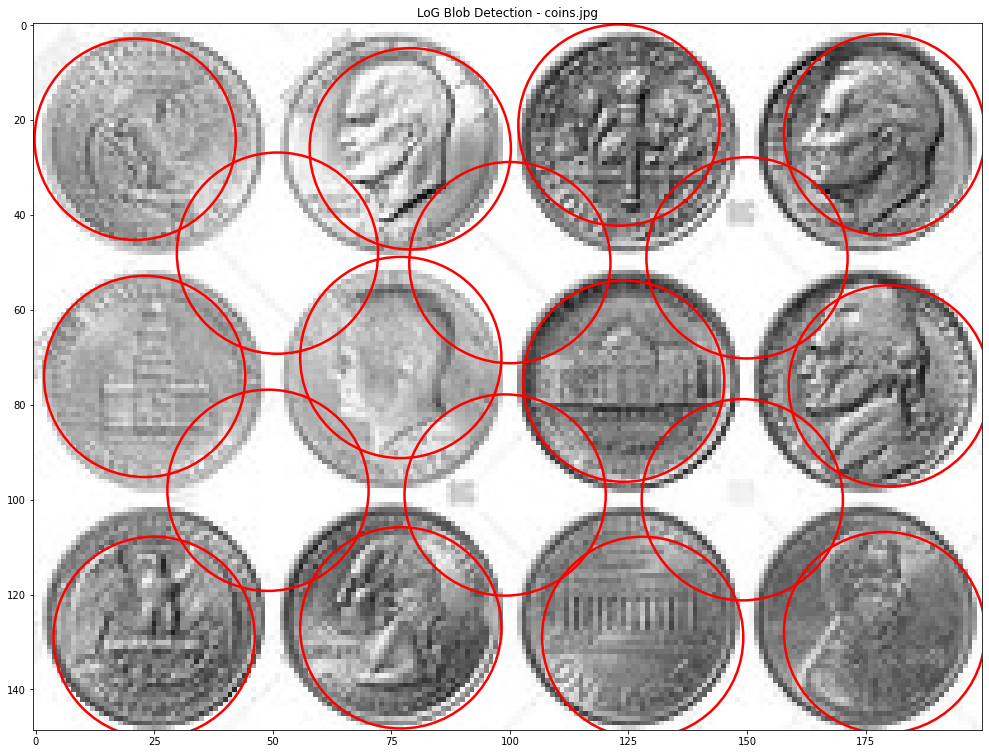

In [11]:
scales_list = [15]
process_image("data", "coins.jpg", scales_list, prune_border_blobs=True)

The blobs are slightly decentered with respect to the center of the coins. Nevertheless, the algorithm succesfully managed to recognize both the dark blobs (the coins) and the bright ones (the interstices between them).

## 4. Results

In the following the algorithm is tested with some much more realistic images.

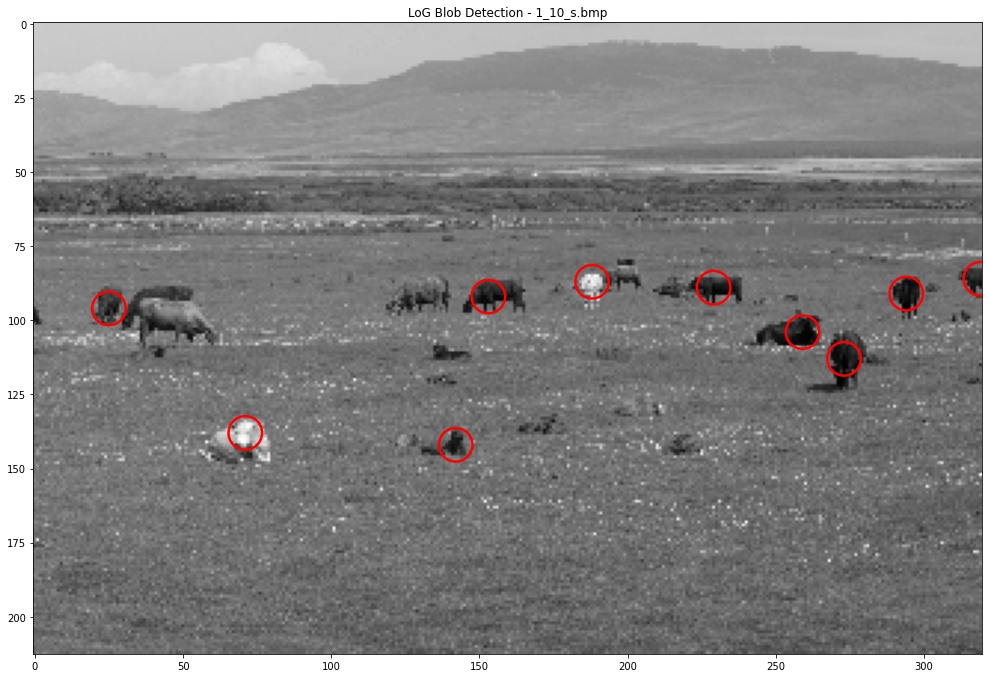

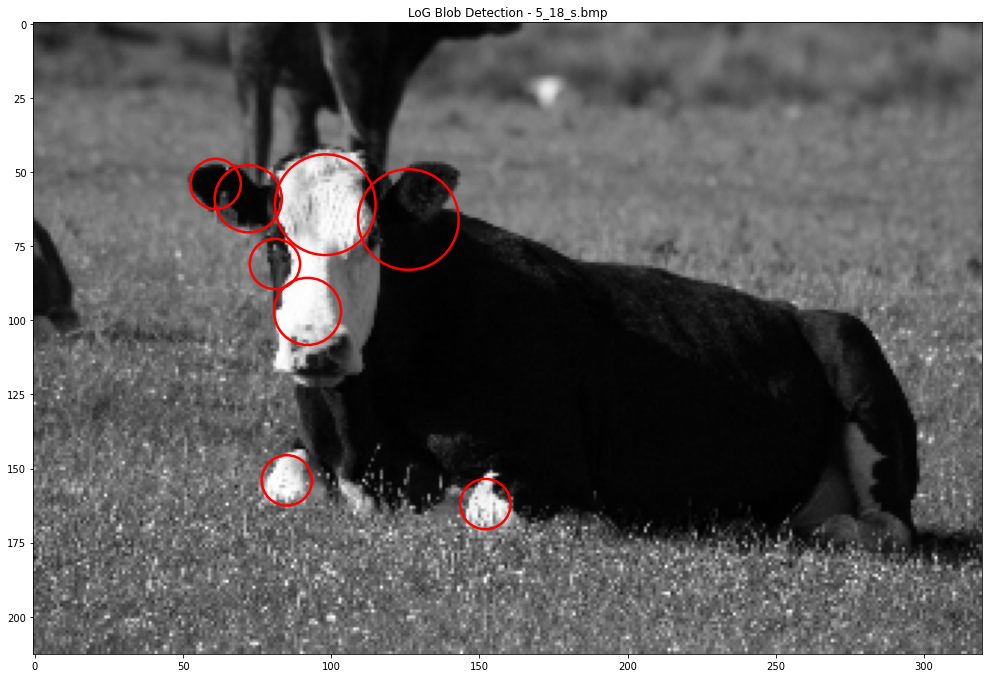

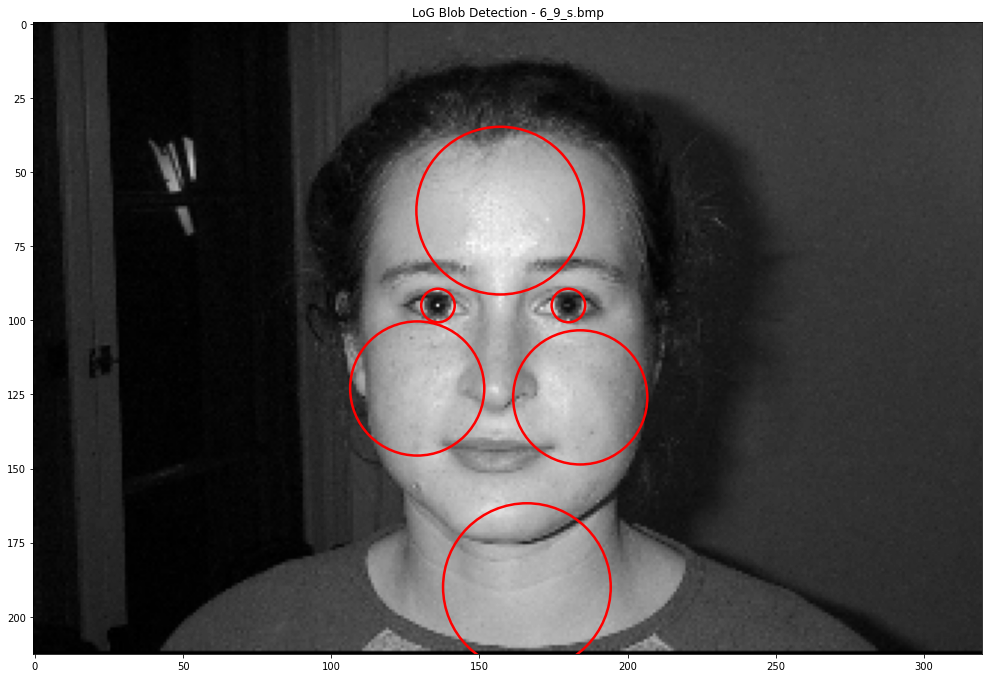

In [16]:
image_files = ["1_10_s.bmp", "5_18_s.bmp", "6_9_s.bmp"]
scales_lists = [[4], [6, 8, 12, 90], [4, 16, 20]]
thresholds = [1050, 2400, 2700]

for image_file, scales_list, threshold in zip(image_files, scales_lists, thresholds):
    process_image("data", image_file, scales_list, threshold = threshold)

The common practice in blob detection is to choose a logaritmic or linear range of scales. Still, as I had to test the algorithm on just a few images known in advance, I manually chose the scales which gave the best results. The processing required some fine tuning to select the proper scales and thresholds, but eventually the results look great.  
The detector was able to identify the right regions of interest in each of the three images: it managed to locate many of the animals (the darkest and brightest ones) in the first image, to spot the snout and the paws of the cow in the second image and to detect the eyes, chicks, neck and forhead of the woman depicted in the third one.  
The thresholds were voluntarily set to quite high values to eliminate background noise. Still, interesting results can be found by lowering the threshold and the scale of the first image.

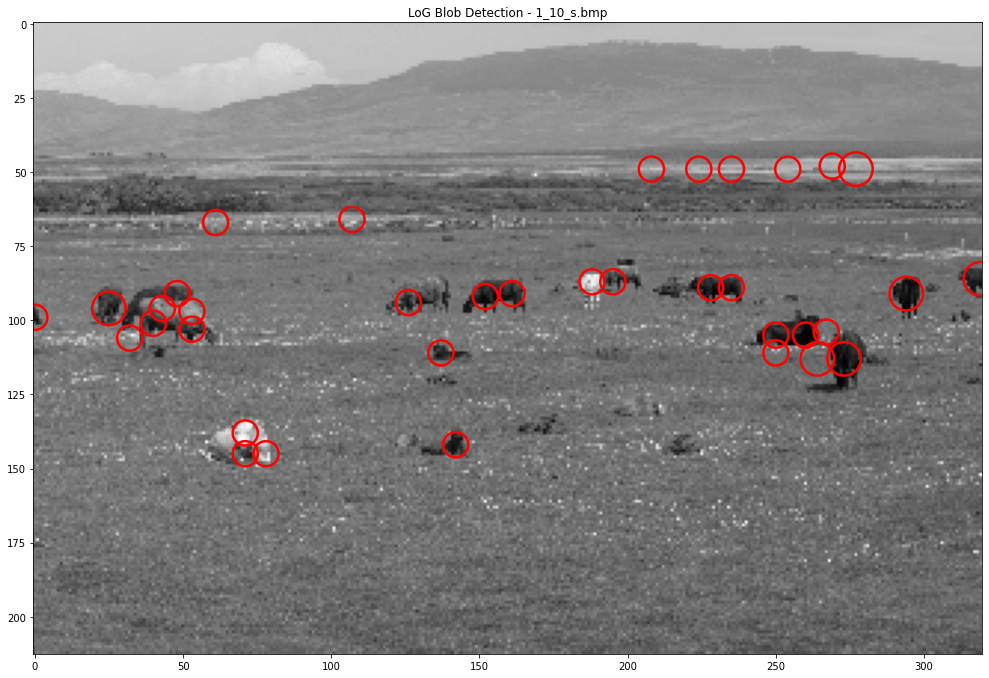

In [13]:
process_image("data", "1_10_s.bmp", scales_list = [3, 4], threshold = 800)

As shown in the picture, by doing this, the algorithm manages to spot almost each animal of the picture, but noise increases with respect to previous result, expecially from the background. Between the two results, the first one was taken as first choice because of its higher precision. Still, the second is worth being shown because of its higher recall.

## 5. Personal Considerations

The coding process was straightforward: I followed with as much attention as possible the steps described during the lectures and finally got satisfying results.  
The main weekpoint of this implementation, at least computationally speaking, is the triple nested for loop in the detect_blobs function, needed to find the relative maxima in the scale-space. This is a true bottleneck, but unexpectedly I did not manage to find an accessible high-performing library function to solve the problem of finding relative etrema in a 3D tensor, so I had to implement it by myself, and the triple nested for loop was the easiest way to do it. Of course, this is not an issue when processing few images in small scale-spaces, but could become a problem when processing a higher number of images in bigger scale-spaces. In such a context it would be useful to have of a precompiled and high-performing version of that piece of software.

To conclude, I would like to point out that this was my first (mini-)project about image processing and that, as expected, the hands-on experience taught me a lot, apart from beign very funny and stimulating.